<a href="https://colab.research.google.com/github/stanley1208/AI-Learning/blob/main/Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.models import resnet50,ResNet50_Weights
from torchvision.models import resnet18,ResNet18_Weights
import matplotlib.pyplot as plt


In [3]:
transform_train=transforms.Compose([
    transforms.RandomCrop(32,padding=5),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])


transform_test=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self,in_channels,out_channels):
    super().__init__()

    self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1)
    self.bn1=nn.BatchNorm2d(out_channels)

    self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
    self.bn2=nn.BatchNorm2d(out_channels)

    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)

  def forward(self,x):
    x=F.relu(self.bn1(self.conv1(x))) # (B,out,H,W)
    x=F.relu(self.bn2(self.conv2(x))) # (B,out,H,W)
    x=self.pool(x)                    # (B,out,H/2,W/2)
    return x

In [ ]:
class MiniVGG(nn.Module):
  def __init__(self):
    super().__init__()
    self.block1=ConvBlock(3,32) # [B,3,32,32]-> [B,32,16,16]
    self.block2=ConvBlock(32,64)  # [B,16,16,16]->[B,64,8,8]

    self.gap=nn.AdaptiveMaxPool2d((1,1))  # [B,64,8,8]-> [B,64,1,1]
    self.fc=nn.Linear(64,10)

  def forward(self,x):
    x=self.block1(x)
    x=self.block2(x)
    x=self.gap(x)     # [B,64,1,1]
    x=x.view(x.size(0),-1)    #[B,64]
    out=self.fc(x)            #[B,10]
    return out

In [ ]:
model=MiniVGG()
x=torch.randn(32,3,32,32)
out=model(x)
print(out.shape)

torch.Size([32, 10])


torch.Size([8, 16, 16, 16])


In [4]:
# # 1. Transforms (convert images to tensors + normalize)
# transform=transforms.Compose([
#     transforms.ToTensor(),
#   ])

# 2. Load CIFAR-10 (train set)
train_data=datasets.CIFAR10(root='./data',train=True,download=True,transform=transform_train)
test_data=datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)


x,y=train_data[0]
print(x.shape,y)
# 3. Wrap in DataLoader
train_loader=DataLoader(train_data,batch_size=32,shuffle=True)
test_loader=DataLoader(test_data,batch_size=32,shuffle=True)



100%|██████████| 170M/170M [00:04<00:00, 34.5MB/s]


torch.Size([3, 224, 224]) 6


In [ ]:
# Create a tiny fake dataset: 100 samples, each 10-dimensional
X=torch.randn(100,3,32,32)
y=torch.randint(0,2,(100,)) # binary labels (0 or 1)

dataset=list(zip(X,y))
dataloader=DataLoader(dataset,batch_size=16,shuffle=True)



In [ ]:
class TinyModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc=nn.Linear(10,2) # input: 10 dims, output: 2 classes

  def forward(self,x):
    return self.fc(x)

In [ ]:
model=MiniVGG() # loss function
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.01)  # optimizer

In [5]:
def train_one_model(model,dataloader,optimiser,crtierion):
  model.train()
  total_loss=0

  for x_batch, y_batch in dataloader:
      # 0️⃣ Reset gradients
      optimizer.zero_grad()
      # 1️⃣ Forward pass
      preds=model(x_batch)  # shape: [batch_size, 2]
      # 2️⃣ Compute loss
      loss=criterion(preds,y_batch) # scalar
      # 3️⃣ Backward pass
      loss.backward()
      # 4️⃣ Optimizer step
      optimizer.step()

      total_loss+=loss.item()


  avg_loss=total_loss/len(dataloader)
  return avg_loss

In [5]:
def evaluate(model,dataloader,criterion):
  model.eval()  # switch to eval mode
  correct=0
  total=0
  total_loss=0.0

  with torch.no_grad():   # no gradients needed for eval
    for x_batch,y_batch in dataloader:
      preds=model(x_batch)  # forward only
      loss=criterion(preds,y_batch)
      predicted=preds.argmax(dim=1) # class with highest score

      correct+=(predicted==y_batch).sum().item()
      total+=y_batch.size(0)
      total_loss+=loss.item()

  avg_loss=total_loss/len(dataloader)
  accuracy=correct/total
  return avg_loss,accuracy

Epoch 1 | Train Loss: 0.7317 | Val Loss: 0.6991 | Val Acc: 0.5400
Epoch 2 | Train Loss: 0.6919 | Val Loss: 0.6934 | Val Acc: 0.5300
Epoch 3 | Train Loss: 0.7030 | Val Loss: 0.6864 | Val Acc: 0.5400


In [ ]:
class TinyCNN(nn.Module):
  def __init__(self):
    super().__init__()
    # conv1: in_channels=3 (RGB), out_channels=16, kernel=3, padding=1 keeps spatial size
    self.conv1=nn.Conv2d(3,16,kernel_size=3,padding=1)
    self.bn1=nn.BatchNorm2d(16)
    # add maxpool
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)

    # conv2: in_channels=16, out_channels=32
    self.conv2=nn.Conv2d(16,32,kernel_size=3,padding=1)
    self.bn2=nn.BatchNorm2d(32)
    # global pooling to reduce spatial dims
    self.gap=nn.AdaptiveAvgPool2d((1,1))

    self.fc=nn.Linear(32,10)

  def forward(self,x):
    # [B,3,32,32] -> [B,16,32,32] -> [B,16,16,16]
    x=self.pool(F.relu(self.bn1(self.conv1(x)))) # [B,16,H,W]
    # [B,16,16,16] -> [B,32,16,16]
    x=F.relu(self.bn2(self.conv2(x))) # [B,32,H,W]
    # [B,32,16,16] -> [B,32,1,1]
    x=self.gap(x)
    # [B,32,1,1] -> [B,32]        # [B,32,1,1]
    x=x.view(x.size(0),-1)
    # [B,32] -> [B,10]        # [B,32]
    out=self.fc(x)                    # [B,2]

    return out


In [ ]:
model=TinyCNN()
print(model)

TinyCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=32, out_features=10, bias=True)
)


In [ ]:
x=torch.randn(16,3,32,32)
out=model(x)
print(out.shape)

torch.Size([16, 10])


In [ ]:
model=TinyCNN()
x=torch.randn(8,3,32,32)
out=model(x)
print(out.shape)

torch.Size([8, 10])


In [11]:
num_epoch=1
for epoch in range(num_epoch):
  train_loss=train_one_model(model,train_loader,optimizer,criterion)
  val_loss,val_accuracy=evaluate(model,test_loader,criterion)

  print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

Epoch 1 | Train Loss: 0.4275 | Val Loss: 0.2464 | Val Acc: 0.9181


In [ ]:
for xb,yb in train_loader:
  print("xb:",xb.shape)
  print("yb:",yb.shape)
  break

xb: torch.Size([32, 3, 32, 32])
yb: torch.Size([32])


In [6]:
# Load pretrained weights
# weights=ResNet50_Weights.IMAGENET1K_V1
weights=ResNet18_Weights.IMAGENET1K_V1
model=resnet18(weights=weights)

# 1) Freeze all layers
for param in model.parameters():
  param.requires_grad=False

# 2) Replace head for CIFAR-10 (10 classes)
model.fc=nn.Linear(model.fc.in_features,10)
# model.fc=nn.Linear(512,10)

# Unfreeze layer3, layer4, fc
for p in model.layer3.parameters():
  p.requires_grad=True
for p in model.layer4.parameters():
  p.requires_grad=True
for p in model.fc.parameters():
  p.requires_grad=True

# 4) Optimizer: trainable params only (layer4 + fc)
trainable_params=[p for p in model.parameters() if p.requires_grad]

optimizer=optim.Adam([
    {"params":model.layer3.parameters(),"lr":5e-5},
    {"params":model.layer4.parameters(),"lr":1e-4},
    {"params":model.fc.parameters(),"lr":1e-3},
],weight_decay=1e-4)


criterion=nn.CrossEntropyLoss()

# 5) Print trainable parameter names (verify)
for name,p in model.named_parameters():
  if p.requires_grad:
    print("TRAIN:",name)
for i,g in enumerate(optimizer.param_groups):
  print(i,"lr=", g["lr"],"num_params",len(g['params']))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]

TRAIN: layer3.0.conv1.weight
TRAIN: layer3.0.bn1.weight
TRAIN: layer3.0.bn1.bias
TRAIN: layer3.0.conv2.weight
TRAIN: layer3.0.bn2.weight
TRAIN: layer3.0.bn2.bias
TRAIN: layer3.0.downsample.0.weight
TRAIN: layer3.0.downsample.1.weight
TRAIN: layer3.0.downsample.1.bias
TRAIN: layer3.1.conv1.weight
TRAIN: layer3.1.bn1.weight
TRAIN: layer3.1.bn1.bias
TRAIN: layer3.1.conv2.weight
TRAIN: layer3.1.bn2.weight
TRAIN: layer3.1.bn2.bias
TRAIN: layer4.0.conv1.weight
TRAIN: layer4.0.bn1.weight
TRAIN: layer4.0.bn1.bias
TRAIN: layer4.0.conv2.weight
TRAIN: layer4.0.bn2.weight
TRAIN: layer4.0.bn2.bias
TRAIN: layer4.0.downsample.0.weight
TRAIN: layer4.0.downsample.1.weight
TRAIN: layer4.0.downsample.1.bias
TRAIN: layer4.1.conv1.weight
TRAIN: layer4.1.bn1.weight
TRAIN: layer4.1.bn1.bias
TRAIN: layer4.1.conv2.weight
TRAIN: layer4.1.bn2.weight
TRAIN: layer4.1.bn2.bias
TRAIN: fc.weight
TRAIN: fc.bias
0 lr= 5e-05 num_params 15
1 lr= 0.0001 num_params 15
2 lr= 0.001 num_params 2


In [7]:
target_layer=model.layer4[-1].conv2

activations=None
grads=None

def forward_hook(module,inp,out):
  global activations
  activations=out.detach()

def backward_hook(module,grad_in,grad_out):
  global grads
  grads=grad_out[0].detach()

target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

In [8]:
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device) # Move the model to the selected device
image,labels=next(iter(test_loader))
image,labels=image.to(device),labels.to(device)

logits=model(image)
pred=logits.argmax(dim=1)

model.zero_grad()
logits[0,pred[0].item()].backward()

In [14]:
print("activations",activations.shape)
print("grads",grads.shape)

sctivations torch.Size([32, 512, 7, 7])
grads torch.Size([32, 512, 7, 7])


In [9]:
# 1) Take image 0
a=activations[0]
g=grads[0]

# 2) Compute channel weights by global-average-pooling the gradients
weights=g.mean(dim=(1,2))  # [512]

# 3) Weighted sum of activations across channels
cam=(weights[:,None,None]*a).sum(dim=0)   #[7,7]

# 4) ReLU (keep only positive evidence)
cam=torch.relu(cam)

# 5) Normalize to [0, 1] for visualization later
cam=(cam-cam.min())/(cam.max()-cam.min()+1e-8)

print("camL",cam.shape,cam.min().item(),cam.max().item())

camL torch.Size([7, 7]) 0.0 0.9999997615814209


In [7]:
xb,yb=next(iter(train_loader))
print(xb.shape,yb.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [10]:
cam_unsampled=F.interpolate(
    cam.unsqueeze(0).unsqueeze(0),# [1,1,7,7]
    size=(224,224),
    mode="bilinear",
    align_corners=False
).squeeze()  # [224,224]


print("cam_unsampled:",cam_unsampled.shape,cam_unsampled.min().item(),cam_unsampled.max().item())


cam_unsampled: torch.Size([224, 224]) 0.0 0.9976375102996826


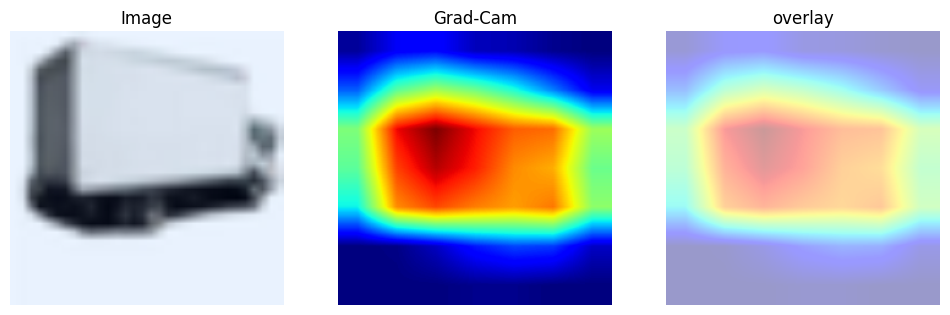

In [11]:
# Take the same image you explained (image 0 from the batch)
img=image[0].detach().cpu() # [3,224,224]
img=img.permute(1,2,0)  # -> [224,224,3]

# Normalize image for display (since it was normalized for training)
img=(img-img.min())/(img.max()-img.min()+1e-8)

heat=cam_unsampled.detach().cpu() # [224,224]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Grad-Cam")
plt.imshow(heat,cmap="jet")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("overlay")
plt.imshow(heat,cmap="jet",alpha=0.4)
plt.axis("off")

plt.show()